In [5]:
%load_ext autoreload
%autoreload 2

In [50]:
# torch
import torch
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import CSVLogger

# utils
import random

# custom utils
from datasets.dataset import *
from helper_utils import display_utils, my_utils
from models.smp_model import CatSegModel
from models.model_utils import build_trainer, infer_set
from models.transforms import data_transforms_v1 as data_transforms

In [7]:
# setup
torch.set_float32_matmul_precision('high')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Configuration
Load Configuration:

In [54]:
config_name = "Unet_resnet34_train.json"
paths, config = my_utils.load_configs(config_name, 'paths_laptop.json') # select paths file

,Key,Value
0,NAME,Unet_resnet34_pretrained_DiceLoss_Tv1
1,MODE,train
2,NUM_EPOCHS,10
3,CLASSES,[pupil]
4,IN_CH,3
5,ARCH,Unet
6,ENCODER,resnet34
7,ENCODER_WEIGHTS,imagenet
8,LOSS,DiceLoss
9,LR,0.0001


Print Transforms:

In [9]:
my_utils.print_transforms(data_transforms)

Transforms for infer set:


,Set,Transform,Details
0,infer,ToImage,ToImage()
1,infer,Resize,"Resize(size=[384], interpolation=608, antialias=True)"
2,infer,Pad,"Pad(padding=[16, 128, 16, 128], fill=[0.5, 0.5, 0.5], padding_mode=constant)"
3,infer,ToDtype,ToDtype(scale=True)




Transforms for train set:


,Set,Transform,Details
0,train,ToImage,ToImage()
1,train,RandomVerticalFlip,RandomVerticalFlip(p=0.5)
2,train,RandomHorizontalFlip,RandomHorizontalFlip(p=0.5)
3,train,RandomResizedCrop,"RandomResizedCrop(size=(640, 640), scale=(0.7, 1.1), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)"
4,train,CustomPerspective,"CustomPerspective(p=0.6, distortion_scale=0.2, interpolation=InterpolationMode.BILINEAR)"
5,train,CenterCrop,"CenterCrop(size=(640, 640))"
6,train,ColorJitter,"ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.1, 0.1))"




Transforms for valid set:


,Set,Transform,Details
0,valid,ToImage,ToImage()
1,valid,CenterCrop,"CenterCrop(size=(640, 640))"


### Data prep

Build dataset:

In [83]:
# get files
train_dataset = SegmentationDataset(os.path.join(paths['train_data_root'], 'train'), data_transforms['train'])
valid_dataset = SegmentationDataset(os.path.join(paths['train_data_root'], 'valid'), data_transforms['valid'])

# dataloaders
train_dl = DataLoader(train_dataset, batch_size=12, shuffle=True, pin_memory=True)#, num_workers=24)
valid_dl = DataLoader(valid_dataset, batch_size=1, shuffle=False, pin_memory=True)#, num_workers=n_cpu)

Plot a few images for example:

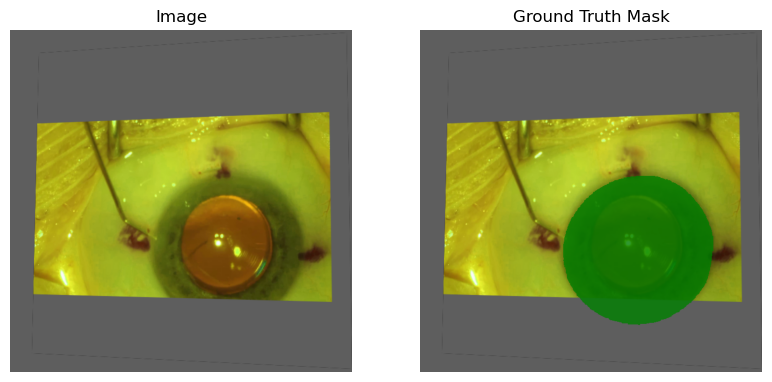

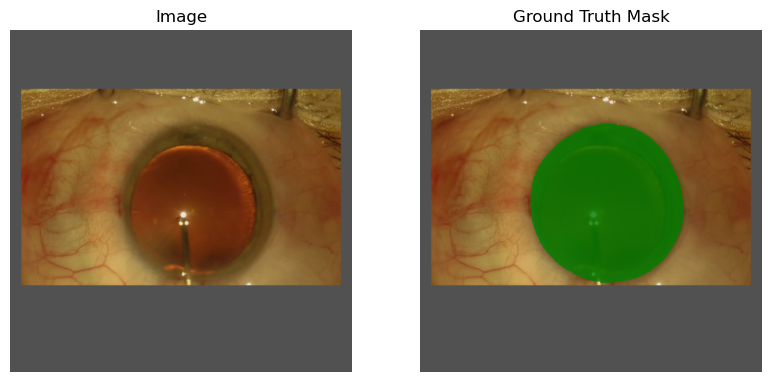

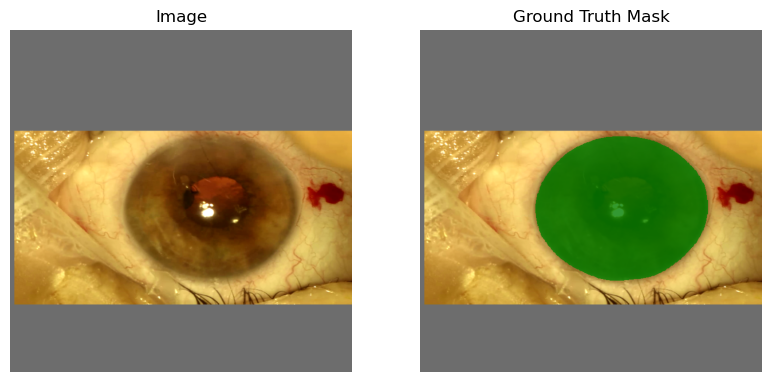

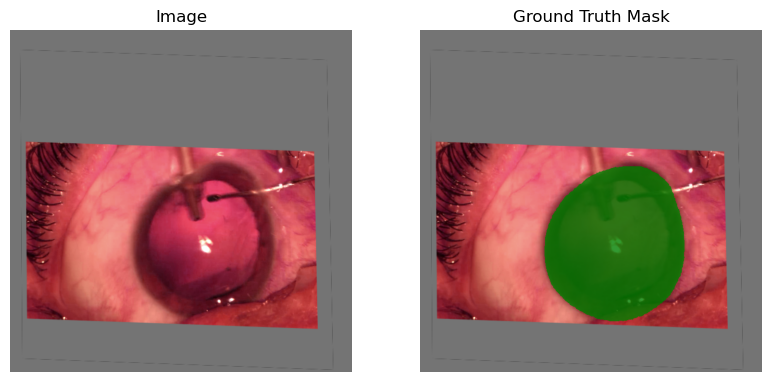

In [7]:
for _ in range(4):
    index = random.randint(0, len(train_dataset) - 1)
    display_utils.display_sample(train_dataset, index)

### Build model
Config load:

In [12]:
# build model
if config['MODE'] == 'train':
    model = CatSegModel(config)
    
elif config['MODE'] == 'load':
    # load model from checkpoint
    model = CatSegModel.load_from_checkpoint(
        checkpoint_path=os.path.join(paths['checkpoint_path'], config['NAME']+'_best-checkpoint.ckpt'),
        hparams_file=os.path.join(paths['log_path'], 'hparams.yaml')
    )

#### Build the PL trainer:

In [15]:
trainer, train_logger = build_trainer(config, paths)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#### Train and plot convergance:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 24.4 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\jonathan\.conda\envs\custom_CatSemSeg\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


<Figure size 1500x500 with 0 Axes>

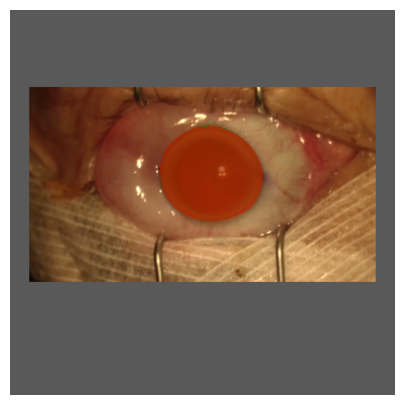

c:\Users\jonathan\.conda\envs\custom_CatSemSeg\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

<Figure size 1500x500 with 0 Axes>

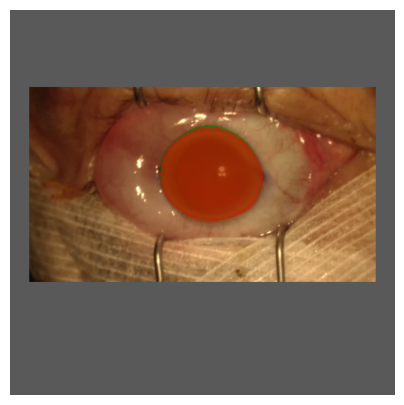

Validation: 0it [00:00, ?it/s]

<Figure size 1500x500 with 0 Axes>

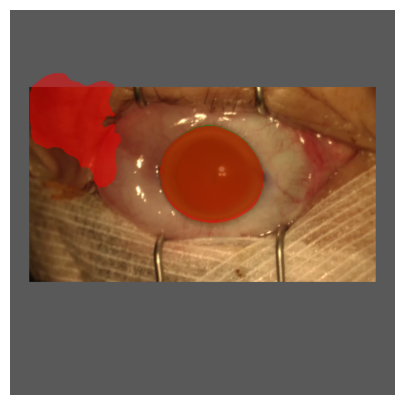

Validation: 0it [00:00, ?it/s]

<Figure size 1500x500 with 0 Axes>

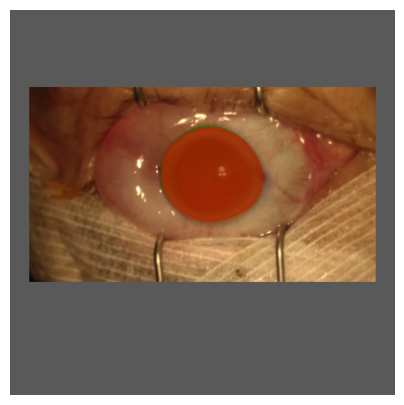

Validation: 0it [00:00, ?it/s]

<Figure size 1500x500 with 0 Axes>

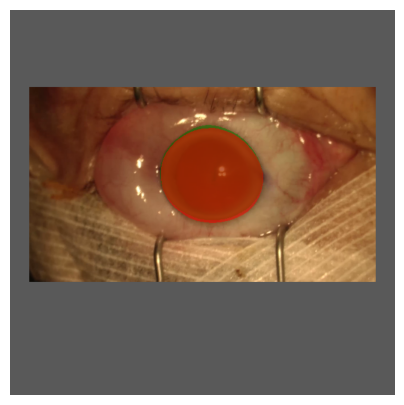

Validation: 0it [00:00, ?it/s]

<Figure size 1500x500 with 0 Axes>

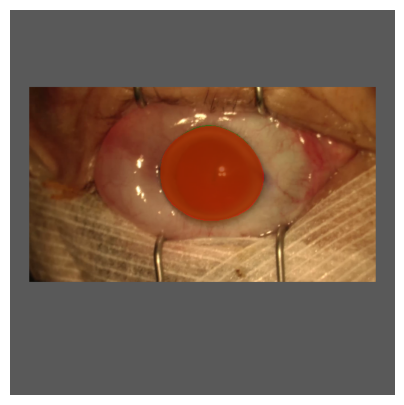

Validation: 0it [00:00, ?it/s]

<Figure size 1500x500 with 0 Axes>

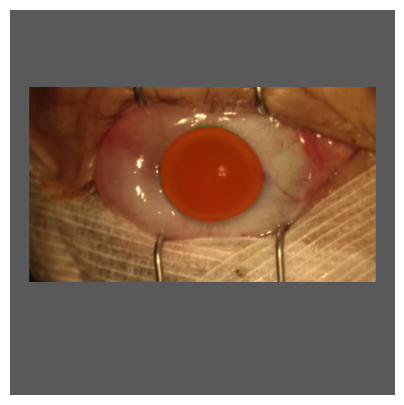

Validation: 0it [00:00, ?it/s]

<Figure size 1500x500 with 0 Axes>

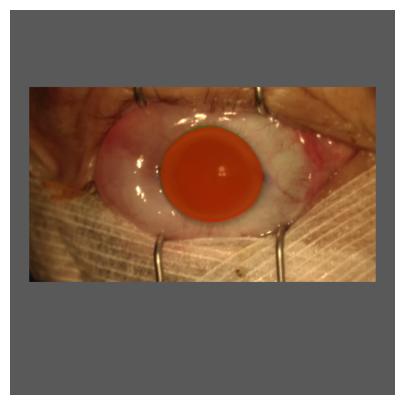

Validation: 0it [00:00, ?it/s]

<Figure size 1500x500 with 0 Axes>

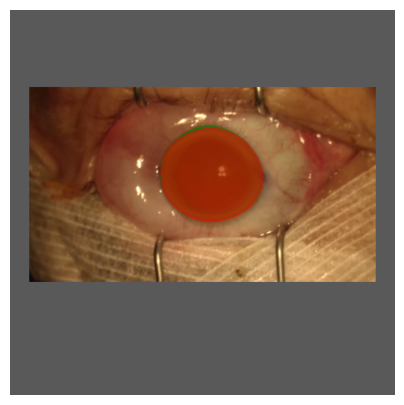

Validation: 0it [00:00, ?it/s]

<Figure size 1500x500 with 0 Axes>

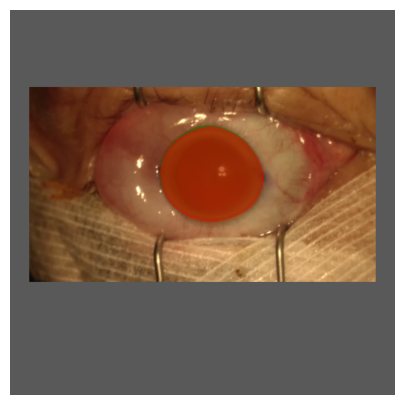

Validation: 0it [00:00, ?it/s]

<Figure size 1500x500 with 0 Axes>

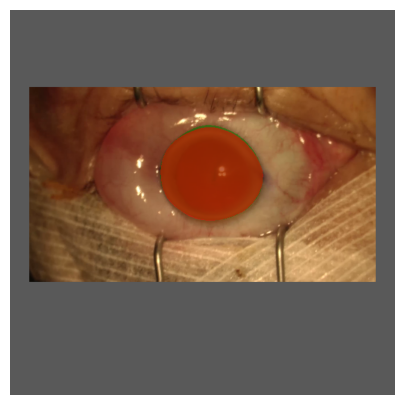

`Trainer.fit` stopped: `max_epochs=10` reached.


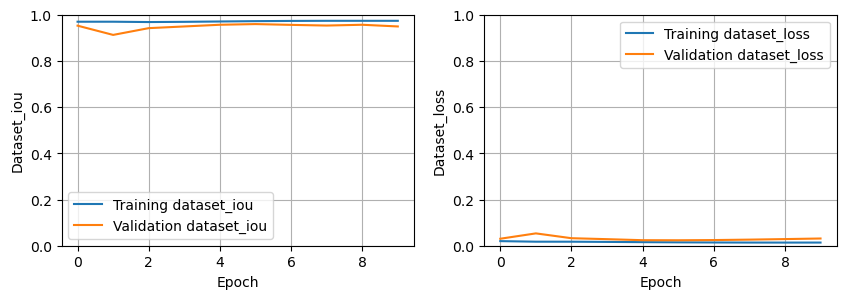

In [16]:
plot_metrics = ['dataset_iou', 'dataset_loss']

if config['MODE'] == 'train':
    # train using the included logger
    trainer.fit(model, 
        train_dataloaders=train_dl, 
        val_dataloaders=valid_dl)
    
    if plot_metrics != None:
        pth = os.path.join(train_logger.log_dir, 'metrics.csv')
        display_utils.plot_losses(pth, plot_metrics)

### Test on Validation data

In [17]:
test_csv_logger = CSVLogger(paths['log_path'], 'test')
trainer.logger = test_csv_logger

model.eval()
with torch.no_grad():
    trainer.test(model= model, dataloaders = valid_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\jonathan\.conda\envs\custom_CatSemSeg\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test_dataset_iou        0.9493776559829712
    test_dataset_loss      0.031251490116119385
   test_per_image_iou       0.9451625347137451
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Plot validation preformance:

In [ ]:
pth = os.path.join(paths['log_path'], 'test', 'metrics.csv')
display_utils.plot_losses(pth, ['image_iou', 'image_loss'], test = True)

### Generate marked validation images
We will begin by generating the predicted masks on the validation dataset, and save them to disk in `train_data_root\infer\NAME`.
Also, we will display a few images.

In [ ]:
time = True # should we time this

save_pth = os.path.join(paths['train_data_root'], 'infer', config['NAME'])
timings = infer_set(model, device, save_pth, dataset=valid_dl.dataset, save=False, to_print=None, time = time, all = True)

# save timings
if time:
    output_file = os.path.join(test_csv_logger.log_dir,'timing.csv')
    os.makedirs(test_csv_logger.log_dir, exist_ok=True)
    with open(output_file, 'w') as f:
        f.write('valid_dataset'+'\n')
        timings.tofile(f, sep='\n', format='%f')

### Out-of-sample Inference
For qualiative evaluation we will generate and display images from out-of-dataset.

First we need to load the inference dataset `infer_dataset`:

In [90]:
# build dataset
infer_dataset = SegmentationInferenceDataset(paths['inference_data_root'], transform=data_transforms['infer'], is_stereo=True)

Generate the masks:

<Figure size 1500x500 with 0 Axes>

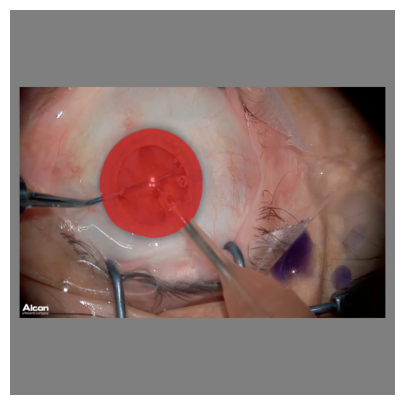

<Figure size 1500x500 with 0 Axes>

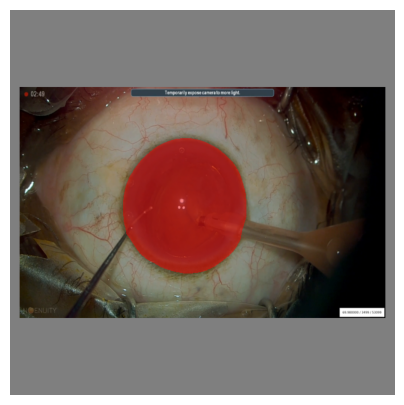

<Figure size 1500x500 with 0 Axes>

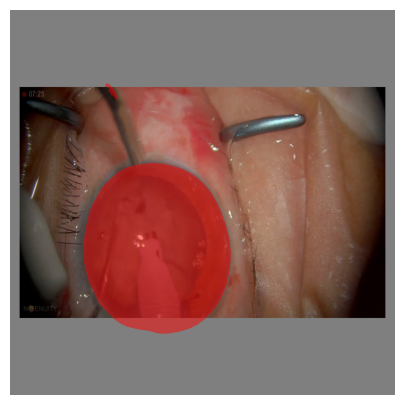

<Figure size 1500x500 with 0 Axes>

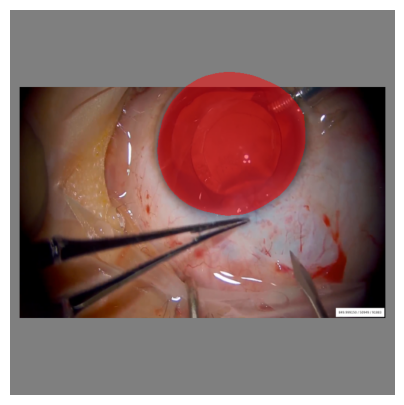

<Figure size 1500x500 with 0 Axes>

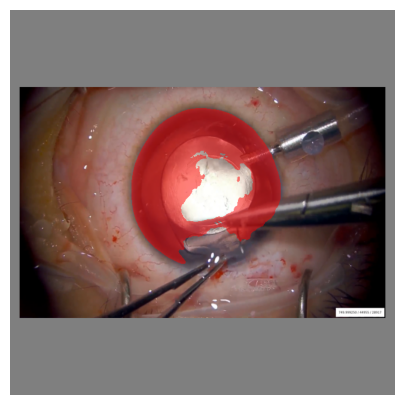

<Figure size 1500x500 with 0 Axes>

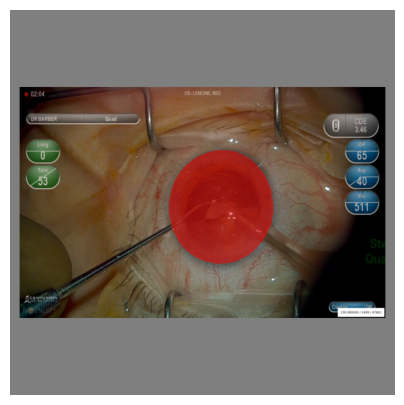

<Figure size 1500x500 with 0 Axes>

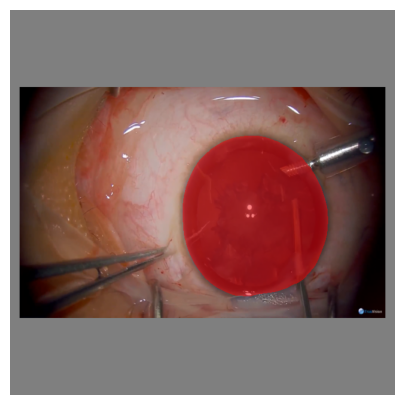

<Figure size 1500x500 with 0 Axes>

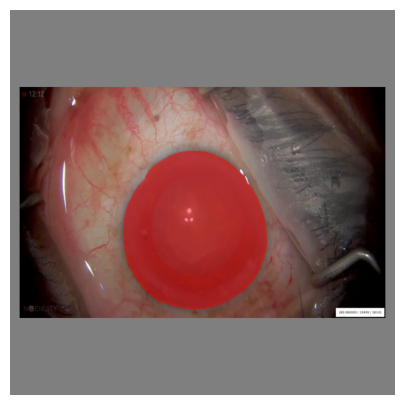

<Figure size 1500x500 with 0 Axes>

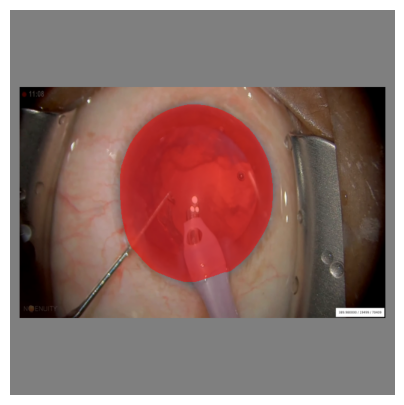

<Figure size 1500x500 with 0 Axes>

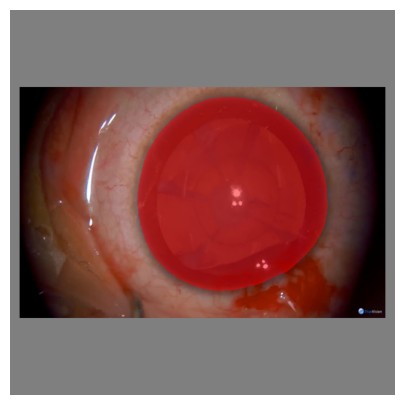

In [68]:
time = True # select
save_pth = os.path.join(paths['inference_save_path'])
timings = infer_set(model, device, save_pth, dataset=infer_dataset, save=True, to_print=4, time = time)

# save timings
if time:
    output_file = os.path.join(test_csv_logger.log_dir,'timing.csv')
    os.makedirs(test_csv_logger.log_dir, exist_ok=True)
    with open(output_file, 'w') as f:
        f.write('inference_dataset'+'\n')
        timings.tofile(f, sep='\n', format='%f')